In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

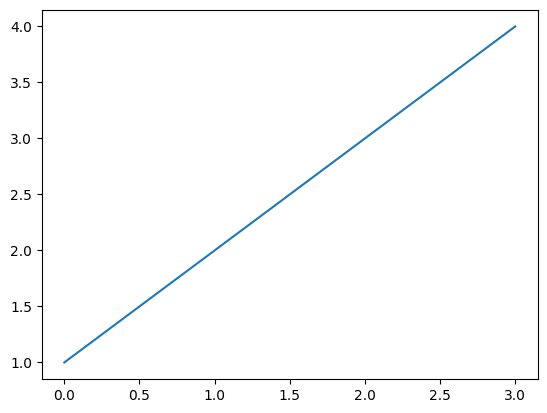

In [3]:
plt.plot([1,2,3,4])

In [4]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [12]:
pwd

'D:\\asy10\\FL_project\\mnist\\Client\\cli1'

In [84]:
# 클라이언트와의 접속 확인 
# 서버로부터 클로벌 모델 파일 명 recv 
# 서버로부터  모델 파일 recv
from socket import *
from os.path import exists
import sys
import os 

    

    
clientSock1 = socket(AF_INET, SOCK_STREAM)
clientSock1.connect(('127.0.0.1', 2266))

print('연결 성공! ')
#filename = '/server-global-eff-model.pth'
filename = 'global-update-2-mnist.pt'
clientSock1.sendall(filename.encode())

data = clientSock1.recv(4096)
data_transferred = 0

if not data:
    print('파일 %s가 서버에 존재 하지 않음' %filename)
    sys.exit()

save_dir = os.path.join('D:\\asy10\\FL_project\\mnist\\Client\\cli1\\model_file_cli1', filename)

print(save_dir)

with open(save_dir, 'wb') as f:
    try :
        while data:
            f.write(data)
            data_transferred += len(data)
            data = clientSock1.recv(4096)


    except Exception as ex:
        print(ex)
print("파일 %s 받기 완료 : 전송량 %d " %(filename, data_transferred))
clientSock1.close()
    
    

연결 성공! 
D:\asy10\FL_project\mnist\Client\cli1\model_file_cli1\global-update-2-mnist.pt
파일 global-update-2-mnist.pt 받기 완료 : 전송량 5912669 


In [85]:

batch_size = 64
learning_rate = 0.01
num_epochs = 30

In [86]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_data = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Download and load the test data
test_data = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [87]:
len(train_data)//2

30000

In [88]:
len(train_data)

60000

In [89]:
len(test_data)

10000

In [90]:
#valid_size = 0.2
#test_size = 0.1
#num_train = len(train_data)//2 # 50000만개의 데이터셋을 나눔 

#indices = list(range(num_train)) # 0 ~ 24999

#np.random.shuffle(indices) 


### 전체 train data 6만개 

In [91]:
import random

valid_size = 0.2
test_size = 0.1
num_train = len(train_data) # 50000개 중에서 25000개 랜덤 추출 

indices = list(range(num_train)) # 0 ~ 24999
sample_indices = random.sample(indices, num_train//2) # 50000개 중에서 25000개 랜덤 추출 
len(sample_indices)

split = int(np.floor(valid_size * (num_train//2))) # 0.2 * 10000
print(split)
train_idx, valid_idx = sample_indices[split:], sample_indices[:split] # train 20000, valid 5000 개씩 indices 리스트에서 랜덤한 인덱스 가져오기 
print(len(train_idx), len(valid_idx))

6000
24000 6000


In [92]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

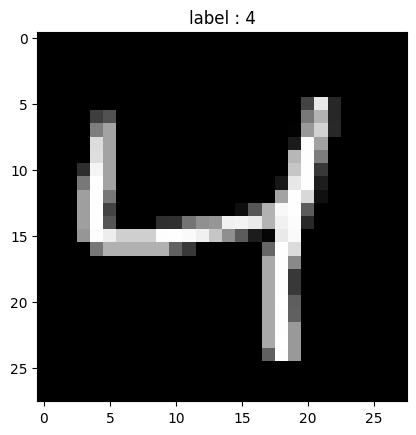

In [93]:
image, label = train_data[2]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [94]:
first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 375
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([64, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([64])


In [95]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

working on gpu


In [96]:
device

device(type='cuda')

In [97]:
classes= [0,1,2,3,4,5,6,7,8,9]

### 서버로 부터 받은 글로벌 모델 파일 로드하기

In [98]:
pwd

'D:\\asy10\\FL_project\\mnist\\Client\\cli1'

In [100]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(self.fc1(out))
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 


model = torch.load('./model_file_cli1/global-update-2-mnist.pt')

In [101]:
model.to(device)

Classifier(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [103]:
from tqdm import tqdm

In [104]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

for e in range(0, n_epochs):
   
    ###################
    # train the model #
    ###################
    model.train()
    gc.collect()
    torch.cuda.empty_cache()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        
        # clear the gradients of all optimized variables
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape) # 모델의 출력과, 실제 정답 비교 
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
    scheduler.step()
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        gc.collect()
        torch.cuda.empty_cache()
        for data, labels in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), './model_file_cli1/mnist-model-update-3.pt')
        valid_loss_min = valid_loss[e]

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 60.26it/s]


Epoch: 0 	Training Loss: 0.011189 	Validation Loss: 0.011004
Epoch: 0 	Training accuracy: 0.997583 	Validation accuracy: 0.997451
Validation loss decreased (inf --> 0.011004).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 69.78it/s]


Epoch: 1 	Training Loss: 0.010452 	Validation Loss: 0.010756
Epoch: 1 	Training accuracy: 0.997875 	Validation accuracy: 0.997673
Validation loss decreased (0.011004 --> 0.010756).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 66.42it/s]


Epoch: 2 	Training Loss: 0.009629 	Validation Loss: 0.010631
Epoch: 2 	Training accuracy: 0.997917 	Validation accuracy: 0.997839
Validation loss decreased (0.010756 --> 0.010631).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 65.44it/s]


Epoch: 3 	Training Loss: 0.008930 	Validation Loss: 0.011144
Epoch: 3 	Training accuracy: 0.998292 	Validation accuracy: 0.997340


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 60.37it/s]


Epoch: 4 	Training Loss: 0.008723 	Validation Loss: 0.011094
Epoch: 4 	Training accuracy: 0.998375 	Validation accuracy: 0.997673


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 78.27it/s]


Epoch: 5 	Training Loss: 0.008489 	Validation Loss: 0.011273
Epoch: 5 	Training accuracy: 0.998375 	Validation accuracy: 0.997507


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 72.70it/s]


Epoch: 6 	Training Loss: 0.007797 	Validation Loss: 0.011443
Epoch: 6 	Training accuracy: 0.998500 	Validation accuracy: 0.997340


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 72.98it/s]


Epoch: 7 	Training Loss: 0.007593 	Validation Loss: 0.011220
Epoch: 7 	Training accuracy: 0.998583 	Validation accuracy: 0.997507


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 69.07it/s]


Epoch: 8 	Training Loss: 0.007490 	Validation Loss: 0.011408
Epoch: 8 	Training accuracy: 0.998583 	Validation accuracy: 0.997119


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 70.15it/s]


Epoch: 9 	Training Loss: 0.007264 	Validation Loss: 0.011405
Epoch: 9 	Training accuracy: 0.998833 	Validation accuracy: 0.997340


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 72.14it/s]


Epoch: 10 	Training Loss: 0.006982 	Validation Loss: 0.011510
Epoch: 10 	Training accuracy: 0.999042 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 67.02it/s]


Epoch: 11 	Training Loss: 0.006753 	Validation Loss: 0.011380
Epoch: 11 	Training accuracy: 0.998917 	Validation accuracy: 0.997340


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 68.66it/s]


Epoch: 12 	Training Loss: 0.006808 	Validation Loss: 0.011424
Epoch: 12 	Training accuracy: 0.998792 	Validation accuracy: 0.997507


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 69.76it/s]


Epoch: 13 	Training Loss: 0.006654 	Validation Loss: 0.011396
Epoch: 13 	Training accuracy: 0.998958 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 66.94it/s]


Epoch: 14 	Training Loss: 0.006634 	Validation Loss: 0.011576
Epoch: 14 	Training accuracy: 0.998875 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 71.87it/s]


Epoch: 15 	Training Loss: 0.006707 	Validation Loss: 0.011465
Epoch: 15 	Training accuracy: 0.999000 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 66.66it/s]


Epoch: 16 	Training Loss: 0.006595 	Validation Loss: 0.011511
Epoch: 16 	Training accuracy: 0.999083 	Validation accuracy: 0.997340


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 71.00it/s]


Epoch: 17 	Training Loss: 0.006378 	Validation Loss: 0.011510
Epoch: 17 	Training accuracy: 0.999000 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 64.56it/s]


Epoch: 18 	Training Loss: 0.006726 	Validation Loss: 0.012184
Epoch: 18 	Training accuracy: 0.998750 	Validation accuracy: 0.996842


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 69.63it/s]


Epoch: 19 	Training Loss: 0.006864 	Validation Loss: 0.011431
Epoch: 19 	Training accuracy: 0.998958 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 66.81it/s]


Epoch: 20 	Training Loss: 0.006344 	Validation Loss: 0.011514
Epoch: 20 	Training accuracy: 0.998958 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 68.02it/s]


Epoch: 21 	Training Loss: 0.006497 	Validation Loss: 0.011547
Epoch: 21 	Training accuracy: 0.999042 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 63.94it/s]


Epoch: 22 	Training Loss: 0.006398 	Validation Loss: 0.011433
Epoch: 22 	Training accuracy: 0.999042 	Validation accuracy: 0.997340


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 71.54it/s]


Epoch: 23 	Training Loss: 0.006441 	Validation Loss: 0.011514
Epoch: 23 	Training accuracy: 0.999042 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 64.61it/s]


Epoch: 24 	Training Loss: 0.006320 	Validation Loss: 0.011691
Epoch: 24 	Training accuracy: 0.999208 	Validation accuracy: 0.997119


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 75.26it/s]


Epoch: 25 	Training Loss: 0.006443 	Validation Loss: 0.011627
Epoch: 25 	Training accuracy: 0.999125 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 66.34it/s]


Epoch: 26 	Training Loss: 0.006480 	Validation Loss: 0.011528
Epoch: 26 	Training accuracy: 0.999042 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 68.07it/s]


Epoch: 27 	Training Loss: 0.006223 	Validation Loss: 0.011516
Epoch: 27 	Training accuracy: 0.999167 	Validation accuracy: 0.997174


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 71.43it/s]


Epoch: 28 	Training Loss: 0.006227 	Validation Loss: 0.011508
Epoch: 28 	Training accuracy: 0.999125 	Validation accuracy: 0.996953


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 74.60it/s]

Epoch: 29 	Training Loss: 0.006664 	Validation Loss: 0.011594
Epoch: 29 	Training accuracy: 0.999083 	Validation accuracy: 0.997285


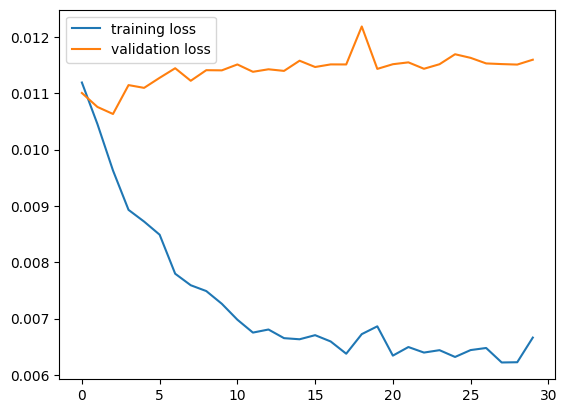

In [105]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()

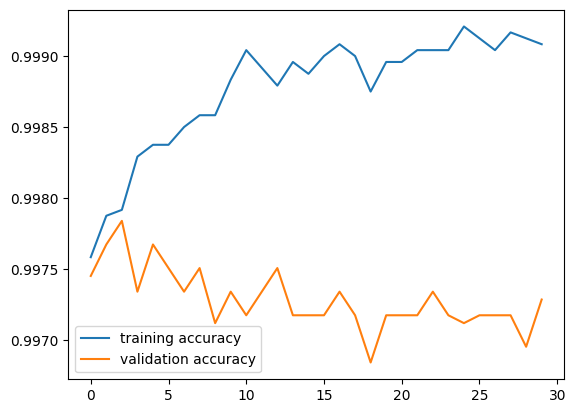

In [106]:
plt.plot(train_acc, label = 'training accuracy')
plt.plot(valid_acc, label = 'validation accuracy')
plt.legend()

In [107]:
pwd

'D:\\asy10\\FL_project\\mnist\\Client\\cli1'

In [108]:
model.load_state_dict(torch.load( './model_file_cli1/mnist-model-update-3.pt'))

<All keys matched successfully>

In [109]:
# track test loss
test_loss = 0.0
test_acc = 0.0

class_correct = torch.zeros(100)
class_total = torch.zeros(100)

model.eval()
# iterate over test data
for data, labels in test_loader:
    # move tensors to GPU if CUDA is available
    data, labels = data.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    logits = model(data)
    # calculate the batch loss
    loss = criterion(logits, labels)
    # update test loss 
    test_loss += loss.item()
    
    ps = F.softmax(logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.reshape(top_class.shape)
    test_acc += torch.mean(equals.type(torch.float)).detach().cpu()
    
    for i in range(len(data)):
        label = labels[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader)
test_acc = test_acc/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.6f}\n'.format(test_acc))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            torch.sum(class_correct[i]), torch.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Loss: 0.024840

Test Accuracy: 0.992038

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 99% (1006/1010)
Test Accuracy of     4: 99% (975/982)
Test Accuracy of     5: 99% (885/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 99% (966/974)
Test Accuracy of     9: 98% (991/1009)


### Server로 모델 파라미터 파일 전송

'D:\\asy10\\FL_project'

In [110]:
# 서버랑 연결 접속 확인 
# client에서 server로 모델 파일 send

from socket import *
from os.path import exists
import sys

clientrSock1 = socket(AF_INET, SOCK_STREAM)
clientrSock1.connect(('127.0.0.1', 2266))

print('연결 성공! ')
filename = 'mnist-model-update-3.pt'
clientrSock1.sendall(filename.encode('utf-8')) ## 파일 이름 전송 


data_transferred = 0


print('파일 %s 전송시작 ! ' %filename)


with open("./model_file_cli1/"+filename, 'rb') as f:
    try :
        data = f.read(2048)
        while data:
            data_transferred += clientrSock1.send(data) # data 전송 
            data = f.read(2048) # 파일에서 2048만큼 읽어오고 
    except Exception as ex:
        print(ex)
print("전송완료 : %s 전송량 %d " %(filename, data_transferred))
clientrSock1.close()

연결 성공! 
파일 mnist-model-update-3.pt 전송시작 ! 
전송완료 : mnist-model-update-3.pt 전송량 5908679 
